In [274]:
import numpy as np
import matplotlib.pyplot as plt

## Possible situations (cases) for the cone of Cherenkov radiation.

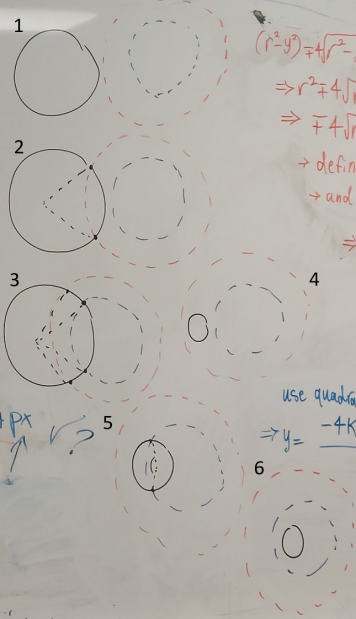

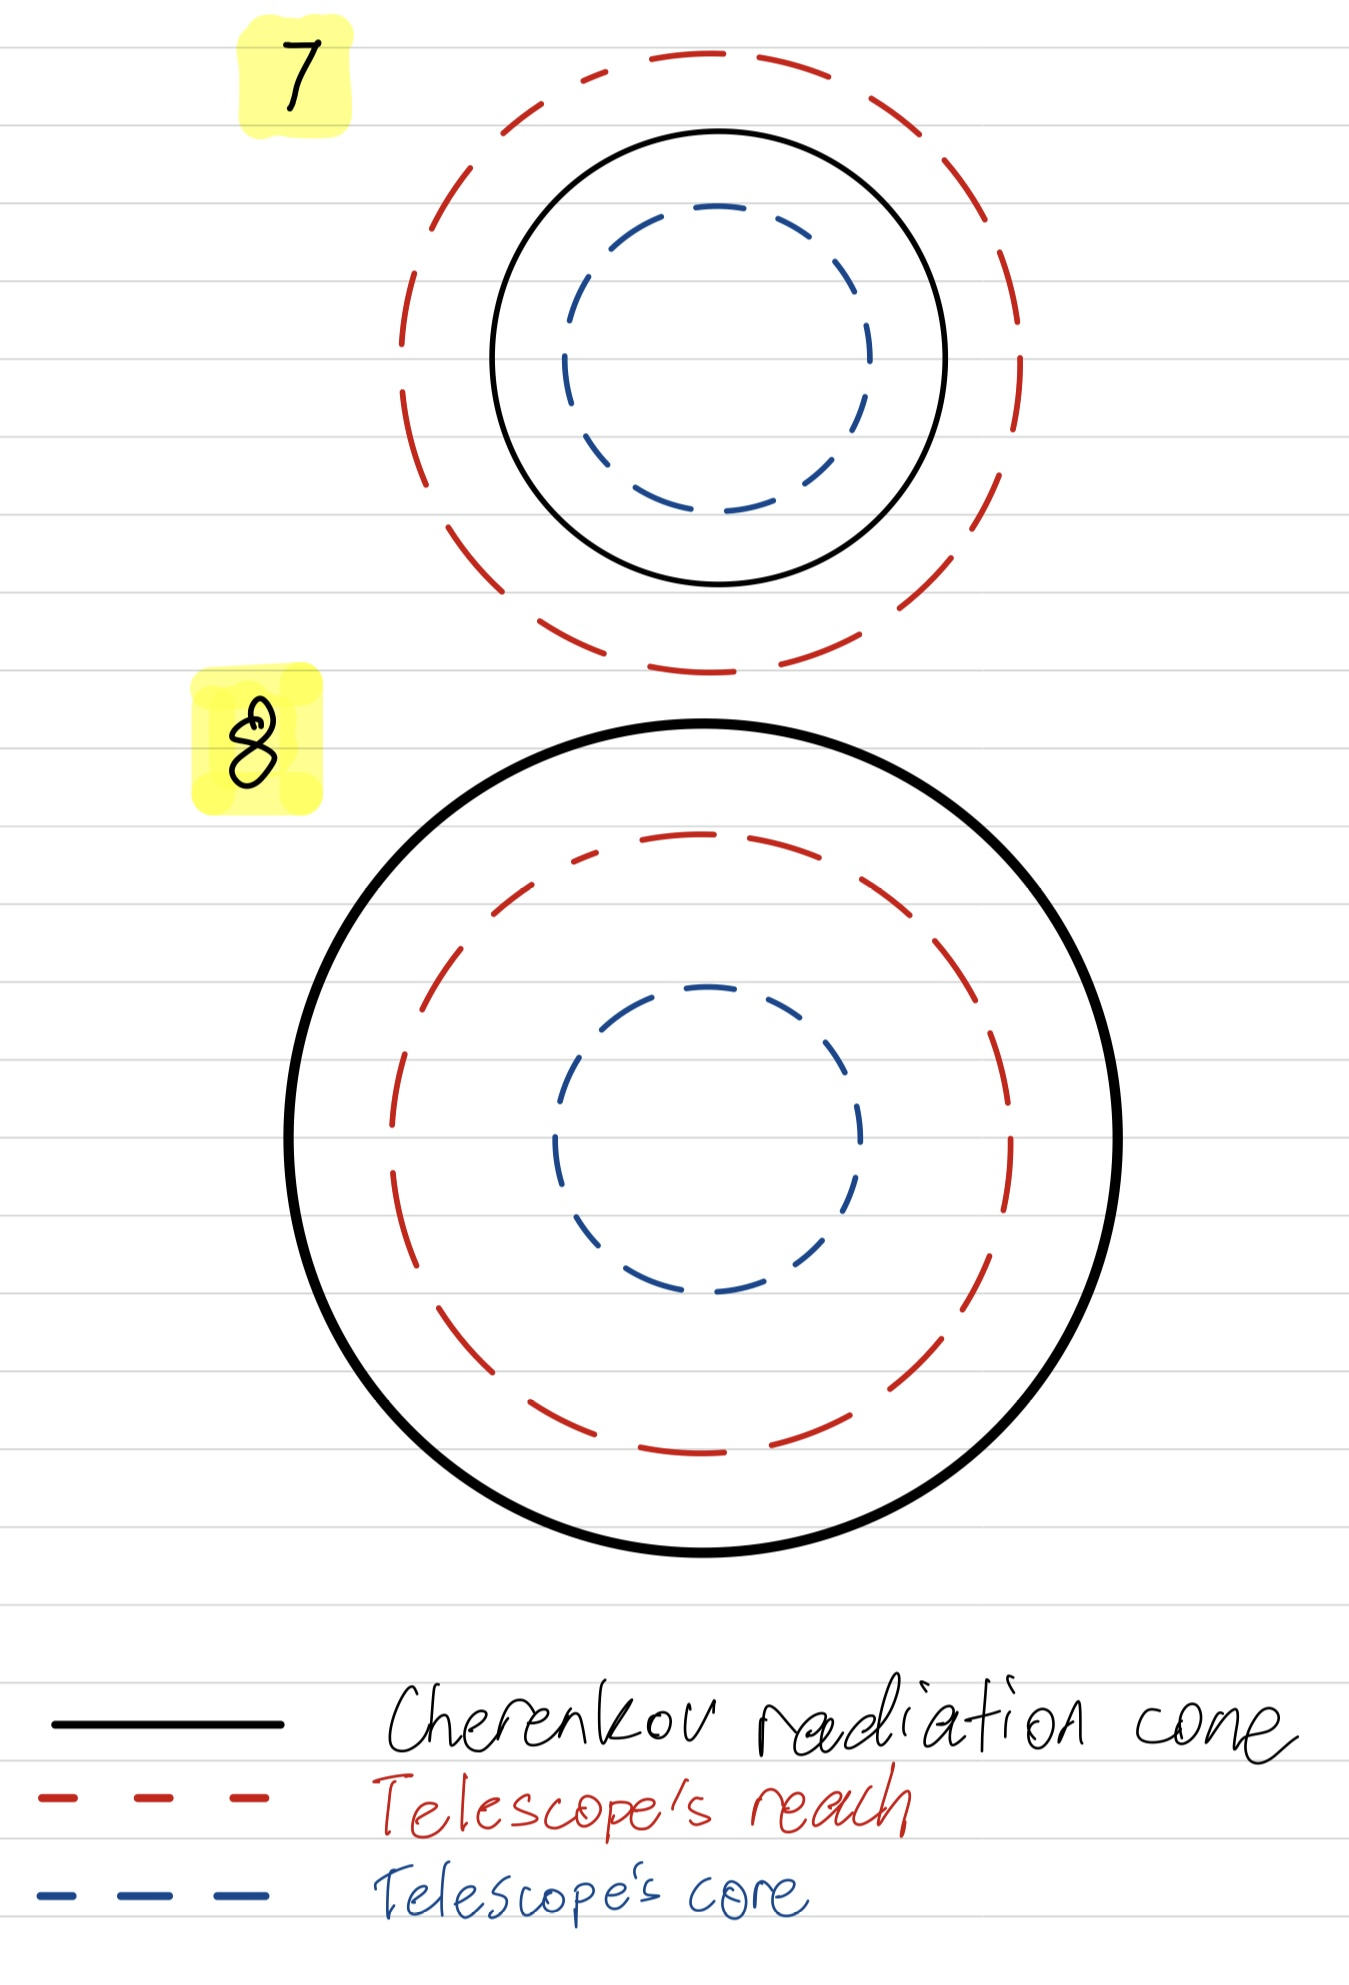

In [275]:
def plot_arc(start, end, radius, centre):
    """
    Plots an arc between start and end with the specified angle.

    Parameters:
    -----------
    start: tuple
        Starting point (x1, y1)

    end: tuple
        Last point (x2, y2)

    angle: float
        Angle (in degrees) defining the arc curvature.

    radius: float
        Radius of the arc.

    centre: tuple
        Coordinates for the centre of the arc.
    """

    # Compute the distance between the points
    d = np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)

    # Compute the start and end angles
    start_angle = np.arctan2(start[1] - centre[1], start[0] - centre[0])
    end_angle = np.arctan2(end[1] - centre[1], end[0] - centre[0])

    # Create a linspace of angles from the start angle to the end angle
    theta_values = np.linspace(start_angle,  end_angle, 100)

    # Generate arc points
    arc_x = centre[0] + radius * np.cos(theta_values)
    arc_y = centre[1] + radius * np.sin(theta_values)

    # Plot the arc
    plt.plot(arc_x, arc_y, color = "magenta", label = "δω")

    # Plot the given points
    plt.scatter(*start, color = 'green' , label = 'Intersection point 1')
    plt.scatter(*end, color = 'darkseagreen', label = 'Intersection point 2')
    plt.text((start[0] + end[0])/2 + 0.15, (start[1] + end[1])/2 + 0.15, "δω")

    # Plot the centre of the arc
    # plt.scatter(*center, color = 'black', marker = 'x', label = 'Cone centre')

    # Formatting
    # plt.xlabel("x-axis")
    # plt.ylabel("y-axis")
    # plt.legend()
    # plt.axis("equal")

    

In [276]:
def graphCircles(cone_pos=(0, 0), tel_pos=(0, 0), r_cone=1, r_tel_core=1, r_tel_reach=2, plot_variables = False, dw = [], start = (0, 0), end = (0, 0)):
  """
  Plots the Cherenkov cone, telescope core and telescope's reach and other optional variables such as ρ and δω.

  Parameters:
  -----------
  cone_pos: tuple
    Coordinates for the centre of the Chrenkov cone.

  tel_pos: tuple 
    Coordinates for the centre of the telescope.

  r_cone: float
    Radius of the Cherenkov cone at the telescope.

  r_tel_core: float
    Radius of the telescope core.

  r_tel_reach: float
    Radius of the reach of the telescope.

  plot_variables: boolean
    Controls whether to plot the other variables (ρ and δω)(if True) or not (if False).

  dw: numpy array
    Array of the δω angles in degrees.

  start: tuple
    Coordinates for the starting intersection point between the Cherenkov cone and the telescope's core and/or reach.

  end: tuple
    Coordinates for the ending intersection point between the Cherenkov cone and the telescope's core and/or reach.
  """

  # Define the circle
  theta = np.linspace(0, 2 * np.pi, 100)
  x = np.cos(theta)
  y = np.sin(theta)

  # Create the plot
  plt.figure(figsize=(6,6))

  # Plot the solid circle
  plt.plot(cone_pos[0] + x*r_cone, cone_pos[1] + y*r_cone, label='Shower Cone', linestyle='-', color='black')

  # Plot the dashed circle
  plt.plot(tel_pos[0] + x*r_tel_core, tel_pos[1] + y*r_tel_core, label='Inner Annulus', linestyle='--', color='red')
  plt.plot(tel_pos[0] + x*r_tel_reach, tel_pos[1] + y*r_tel_reach, label='Outer Annulus', linestyle='--', color='blue')

  # Add labels and title
  plt.title('Shower cone and telescope projection')
  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')

  # Set aspect ratio to equal to make the circle look like a circle
  ax = plt.gca().set_aspect('equal', adjustable='box')

  if plot_variables == True:
    # Create a straight line indicating rho (radius of the cone) along the x-axis
    rho_x = [cone_pos[0], cone_pos[0] + r_cone]
    rho_y = [cone_pos[1], cone_pos[1]]
    plt.plot(rho_x, rho_y, label = 'ρ', linestyle = '-', color = 'green')
    plt.text((cone_pos[0] + cone_pos[0] + r_cone)/2, cone_pos[1] + 0.15, "ρ")
    

    if len(dw) != 0:
      # plot dw
      plot_arc(start, end, r_cone, cone_pos)
      

  # Show legend
  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()

In [277]:
def getIntersectionPoints(new_tel_pos=(0, 0), cone_r=1, tel_r=1):
  # Cone position assumed to be at (0, 0) with radius r
  # Center of telescope at (L, h) with radius R
  # Define constants



  r = cone_r
  R = tel_r
  L = new_tel_pos[0]
  h = new_tel_pos[1]
  K = R**2 - r**2 - L**2 - h**2

  # Define a b and c in quadratic formula
  a = 4*(h**2) + 4*(L**2)
  b = 4*K*h
  c = (K**2) - 4*(L**2)*(r**2)

  # Calculate y-values (roots)
  roots = np.roots([a, b, c])

  x = [None, None]

  for idx, y in enumerate(roots):
    cone_xs = [np.sqrt(r**2-y**2), -np.sqrt(r**2-y**2)]
    annulus_xs = [np.sqrt(R**2 - (y-h)**2) + L, L - np.sqrt(R**2 - (y-h)**2)]

    # Use match to find the correct x coordinate
    match = next((val for val in cone_xs if any(np.isclose(val, a) for a in annulus_xs)), None)
    if match is not None:
        x[idx] = match

  return (x[0], roots[0]), (x[1], roots[1])

points = getIntersectionPoints(new_tel_pos = (1, 1), cone_r = 2, tel_r = 2)
print(points)

((-0.8228756555322952, 1.8228756555322954), (1.8228756555322954, -0.8228756555322952))


## Computing $'\delta\omega'$
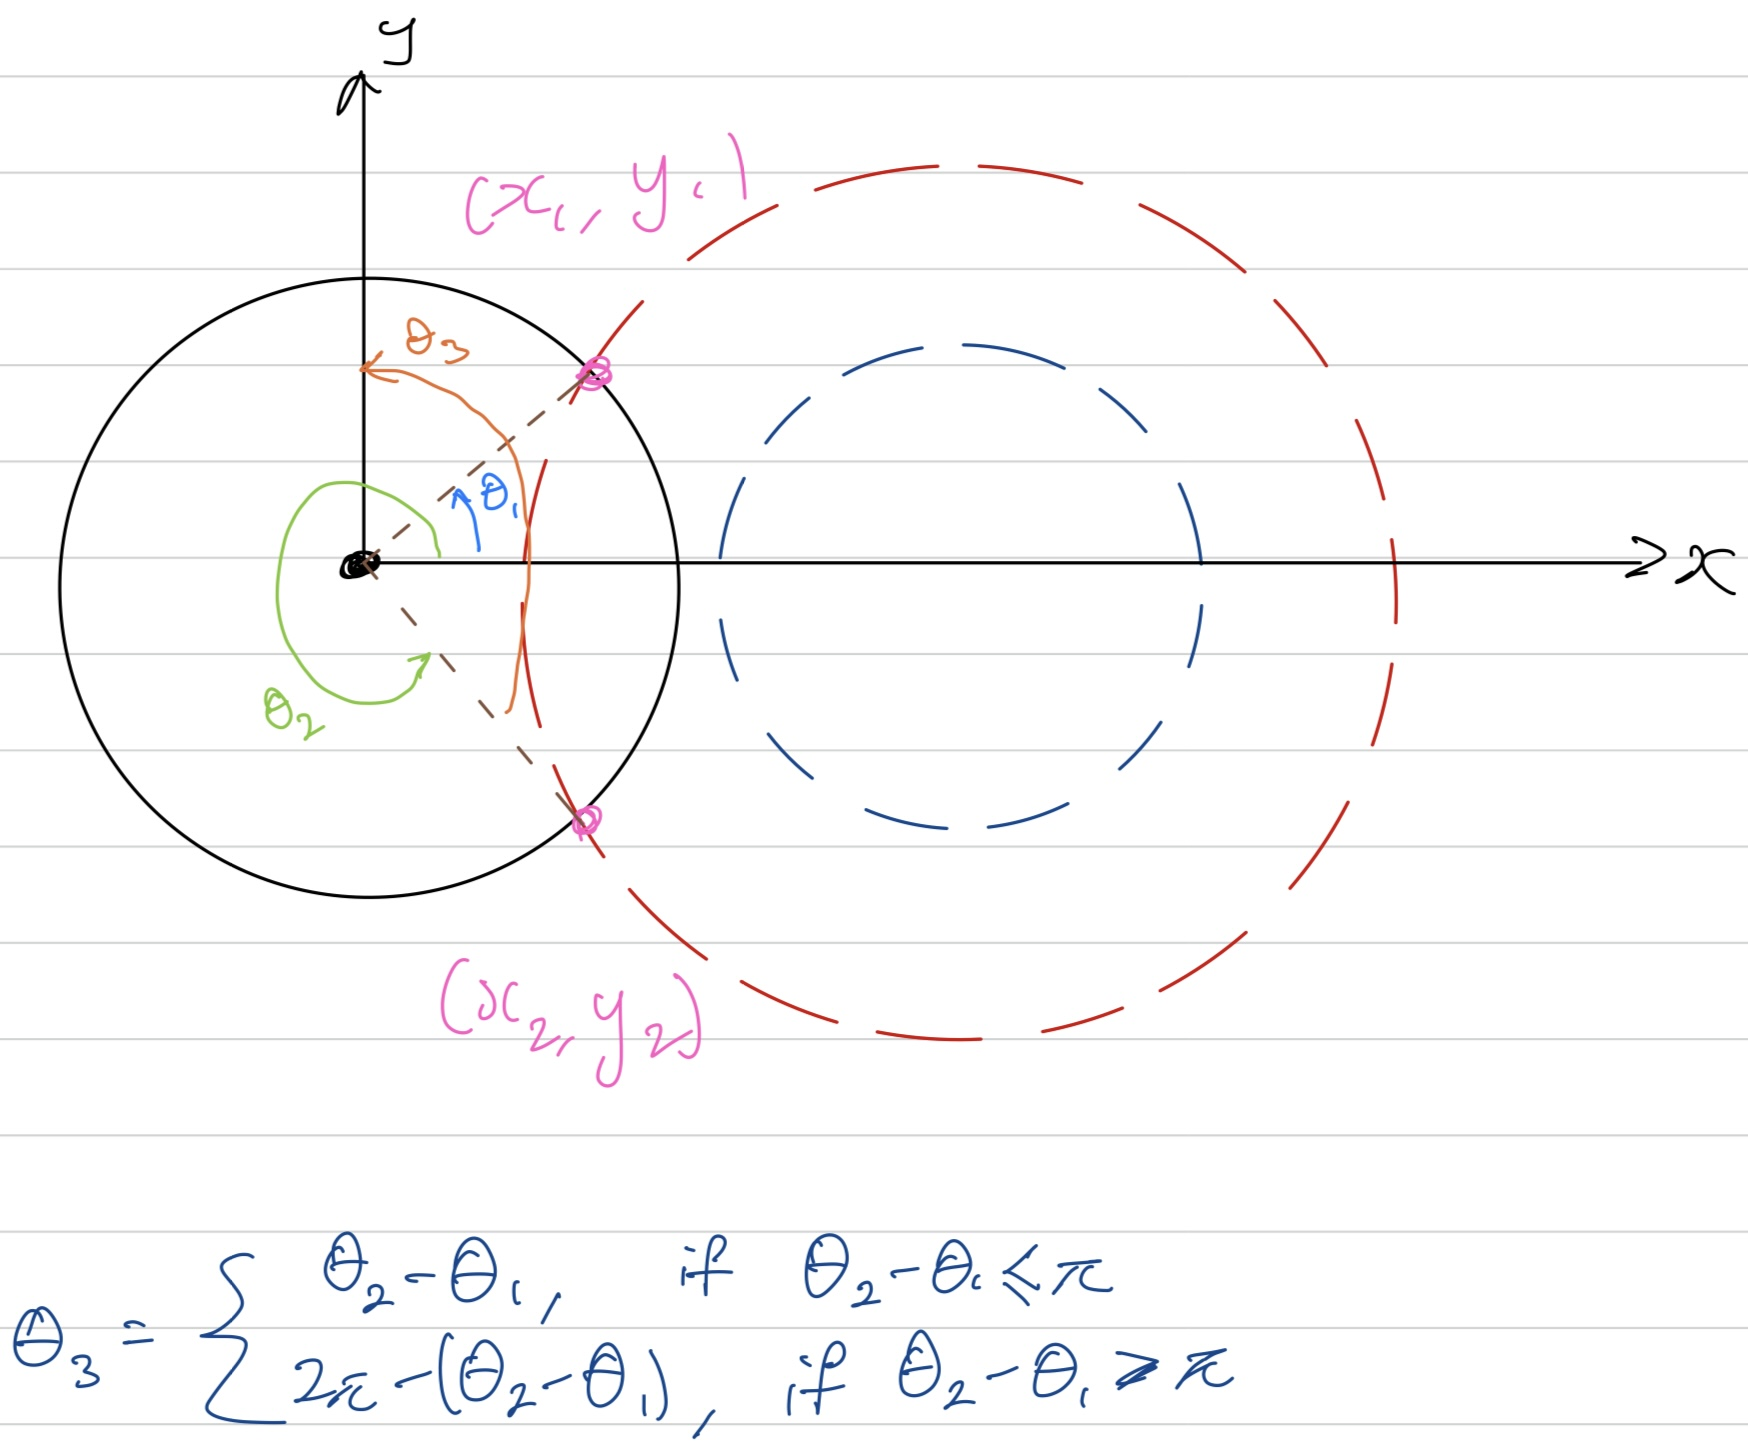

In [278]:
def calculateOmegaFromPoints(point1, point2, arcType = "major", return_other_angles = False):
  # Calculate angles in radians
  angle1 = np.arctan2(point1[1], point1[0])
  angle2 = np.arctan2(point2[1], point2[0])

  # Compute minor arc
  minor_arc = (angle2 - angle1) % (2 * np.pi)

  # Makes sure minor_arc is the smaller arc
  minor_arc = min(minor_arc, 2 * np.pi - minor_arc)

  # Pack the result and the angles used to calculate it into a numpy array as follows: [result, angle1, angle2] and return it if return_other_angles = True
  if arcType == "major" and return_other_angles == True:
    return np.array(2 * np.pi - minor_arc, angle1, angle2)
  
  elif arcType != "major" and return_other_angles == True:
    return np.array(minor_arc, angle1, angle2)


  # If major arc specified, return major arc instead, otherwise return minor arc
  if arcType == "major":
    return 2 * np.pi - minor_arc

  else:
    return minor_arc

In [279]:
def getClosestPoint(point, pair):
  getDistance = lambda p1, p2: np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
  
  # Get distance between intersection points
  p0_dist = getDistance(point, pair[0])
  p1_dist = getDistance(point, pair[1])

  if p0_dist < p1_dist:
    return pair[0]
  elif p0_dist > p1_dist:
    return pair[1]
  else:
    print("Error detected!: Equal distance between target point and pair provided in getClosestPoint function")
    return (0, 0)


In [280]:
def determineArcType(cone_center, annulus_center, inner_radius, outer_radius):
    # Calculate the Euclidean distance
    dist = np.hypot(cone_center[0] - annulus_center[0], cone_center[1] - annulus_center[1])
    
    # Determine the arc type based on the relative position of the cone to the annulus
    if inner_radius < dist < outer_radius:
        return "major"  # Large angle: cone within the annulus
    else:
        return "minor"  # Small angle: cone outside or inside the inner annulus

In [281]:
def getOmegas(cone_pos=(0, 0), tel_pos=(0, 0), r_cone=1, r_tel_core=1, r_tel_reach=2):
  # Shift reference frame so that
  # Shower cone center is at the origin
  new_cone_pos = (0, 0)
  new_tel_pos = (tel_pos[0] - cone_pos[0], tel_pos[1] - cone_pos[1])

  # Define constant
  dist = np.sqrt(new_tel_pos[0]**2 + new_tel_pos[1]**2)

  outside_tel_reach = dist >= r_cone + r_tel_reach
  inside_tel_reach = dist <= r_tel_reach - r_cone
  intersect_tel_reach = ~outside_tel_reach and ~inside_tel_reach

  outside_tel_core = dist >= r_tel_core + r_cone
  inside_tel_core = dist <= r_tel_core - r_cone
  intersect_tel_core = ~outside_tel_core and ~inside_tel_core

  tel_reach_inside_cone = dist <= r_cone - r_tel_reach
  tel_core_inside_cone = dist <= r_cone - r_tel_core


  ### No intersection cases
  # Case 1
  if (outside_tel_reach):
    print("Case 1 identified.")
    return []
  
  # Case 4
  elif (inside_tel_reach and outside_tel_core):
    print("Case 4 identified.")
    return [2*np.pi]
  
  # Case 6
  elif (inside_tel_core):
    print("Case 6 identified.")
    return []
  
  # Case 7
  elif (inside_tel_reach and tel_core_inside_cone):
    print("Case 7 identified.")
    return [2*np.pi]
  
  # Case 8
  elif (tel_reach_inside_cone):
    print("Case 8 identified.")
    return []


  ### One pair of intersection points
  # Case 2
  if (intersect_tel_reach and not intersect_tel_core):
    print("Case 2 identified.")
    points = getIntersectionPoints(new_tel_pos, r_cone, r_tel_reach)
    print("Intersection points (x, y): ", points)
    omega = calculateOmegaFromPoints(points[0], points[1], arcType = determineArcType(new_cone_pos, new_tel_pos, r_tel_core, r_tel_reach))
    return [omega]
  
  # Case 5
  elif (intersect_tel_core and not intersect_tel_reach):
    print("Case 5 identified.")
    points = getIntersectionPoints(new_tel_pos, r_cone, r_tel_core)
    print("Intersection points (x, y): ", points)
    omega = calculateOmegaFromPoints(points[0], points[1], arcType = determineArcType(new_cone_pos, new_tel_pos, r_tel_core, r_tel_reach))
    return [omega]


  ### 2 pairs of intersection points (2 omega angles)
  # Case 3
  if (intersect_tel_reach and intersect_tel_core):
    print("Case 3 identified.")
    core_pair = getIntersectionPoints(new_tel_pos, r_cone, r_tel_core)
    reach_pair = getIntersectionPoints(new_tel_pos, r_cone, r_tel_reach)
    print("core_pair: ", core_pair)
    print("reach_pair: ", reach_pair)

    # Use core_pair as a reference and compare to reach_pair
    pair1 = (core_pair[0], getClosestPoint(core_pair[0], reach_pair))
    pair2 = (core_pair[1], getClosestPoint(core_pair[1], reach_pair))

    print("Closest pair of intersection points 1: ", pair1)
    print("Closest pair of intersection points 2: ", pair2)

    omega1 = calculateOmegaFromPoints(pair1[0], pair1[1], arcType = "minor")
    omega2 = calculateOmegaFromPoints(pair2[0], pair2[1], arcType = "minor")

    # It should be that omega1 = omega2
    return [omega1, omega2]

  print("NO CASES MATCHED????")
  return []

# getOmegas Test
## Test with case 1

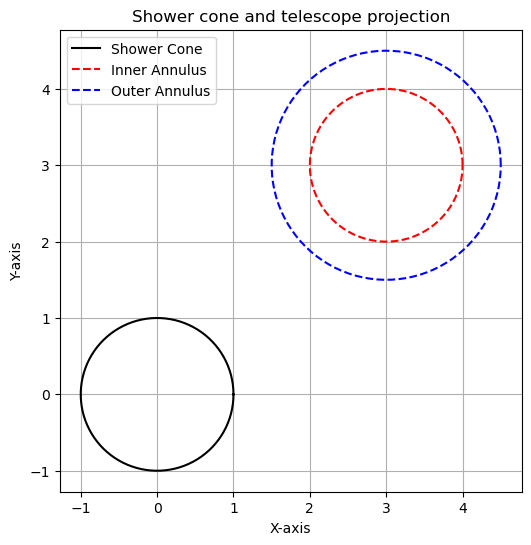

Case 1 identified.
[]


In [282]:
graphCircles(cone_pos=(0, 0), tel_pos=(3, 3), r_cone=1, r_tel_core=1, r_tel_reach=1.5)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(3, 3), r_cone=1, r_tel_core=1, r_tel_reach=1.5)) * 180/np.pi)

## Test with case 2

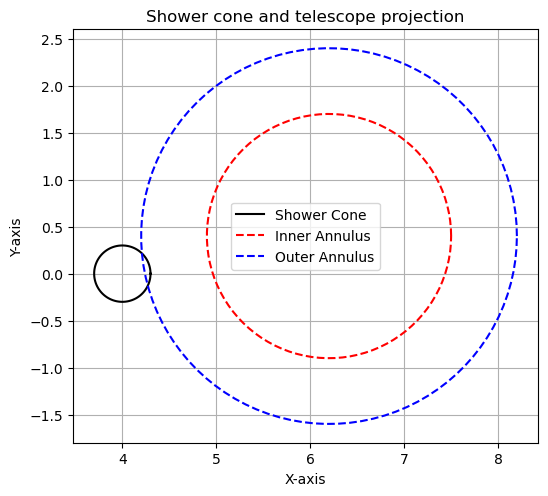

Case 2 identified.
Intersection points (x, y):  ((0.20851038510943307, 0.215692881898119), (0.27108961489056727, -0.12849288189811894))
[71.33035545]


In [283]:
graphCircles(cone_pos=(4, 0), tel_pos=(6.2, 0.4), r_cone=0.3, r_tel_core=1.3, r_tel_reach=2)
print(np.array(getOmegas(cone_pos=(4, 0), tel_pos=(6.2, 0.4), r_cone=0.3, r_tel_core=1.3, r_tel_reach=2)) * 180/np.pi)

## Test for case 3

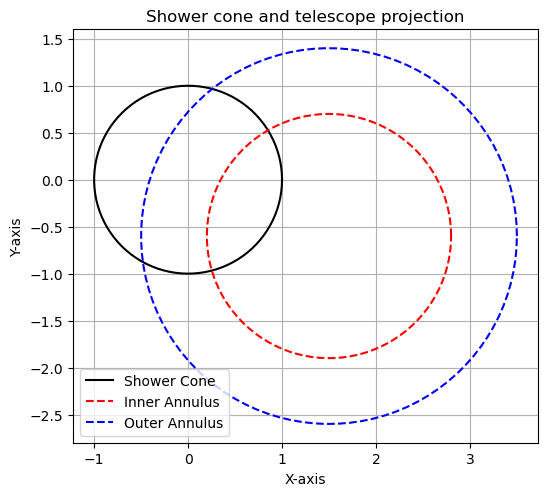

Case 3 identified.
core_pair:  ((0.25301506444541033, -0.967462338886473), (0.8504332114166581, 0.5260830285416453))
reach_pair:  ((0.2566063957392741, 0.9665159893481841), (-0.4807443267737562, -0.8768608169343912))
Closest pair of intersection points 1:  ((0.25301506444541033, -0.967462338886473), (-0.4807443267737562, -0.8768608169343912))
Closest pair of intersection points 2:  ((0.8504332114166581, 0.5260830285416453), (0.2566063957392741, 0.9665159893481841))
[43.39002663 43.39002663]


In [284]:
graphCircles(cone_pos=(0, 0), tel_pos=(1.5, -0.6), r_cone=1, r_tel_core=1.3, r_tel_reach=2)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(1.5, -0.6), r_cone=1, r_tel_core=1.3, r_tel_reach=2)) * 180/np.pi)

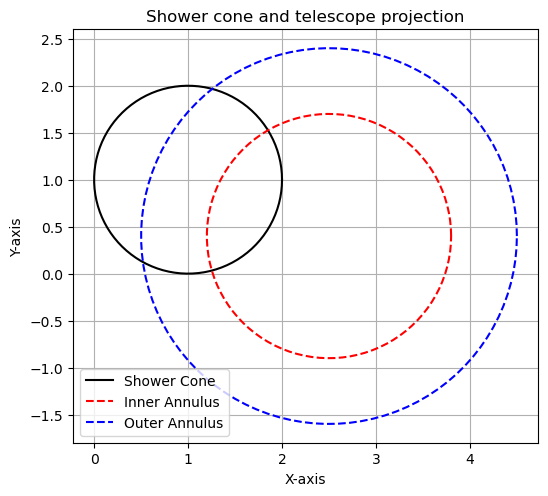

Case 3 identified.
core_pair:  ((0.25301506444541033, -0.967462338886473), (0.8504332114166581, 0.5260830285416453))
reach_pair:  ((0.2566063957392741, 0.9665159893481841), (-0.4807443267737562, -0.8768608169343912))
Closest pair of intersection points 1:  ((0.25301506444541033, -0.967462338886473), (-0.4807443267737562, -0.8768608169343912))
Closest pair of intersection points 2:  ((0.8504332114166581, 0.5260830285416453), (0.2566063957392741, 0.9665159893481841))
[43.39002663 43.39002663]


In [285]:
graphCircles(cone_pos=(1, 1), tel_pos=(2.5, 0.4), r_cone=1, r_tel_core=1.3, r_tel_reach=2)
print(np.array(getOmegas(cone_pos=(1, 1), tel_pos=(2.5, 0.4), r_cone=1, r_tel_core=1.3, r_tel_reach=2)) * 180/np.pi)

## Testing for Case 4

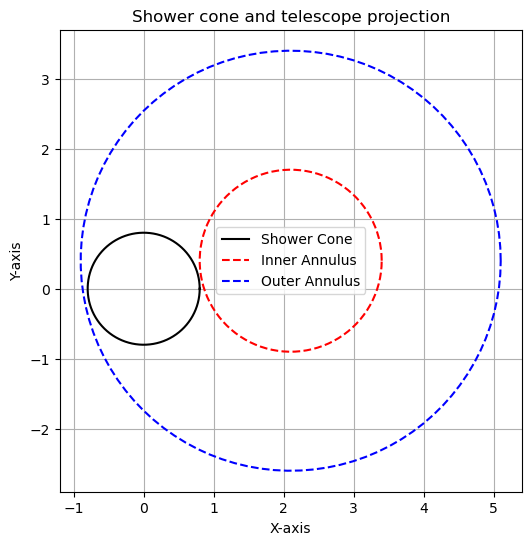

Case 4 identified.
[360.]


In [286]:
graphCircles(cone_pos=(0, 0), tel_pos=(2.1, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(2.1, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

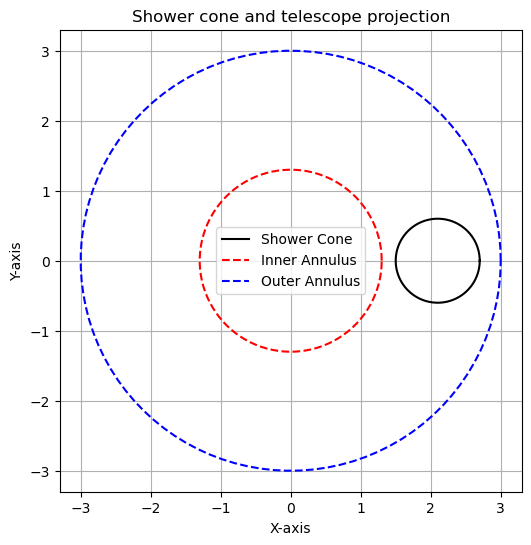

Case 4 identified.
[360.]


In [287]:
graphCircles(cone_pos=(2.1, 0), tel_pos=(0, 0), r_cone=0.6, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(2.1, 0), tel_pos=(0, 0), r_cone=0.6, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

* Works when cone is centred and the origin and also when cone is not centred at the origin.

## Testing for Case 5

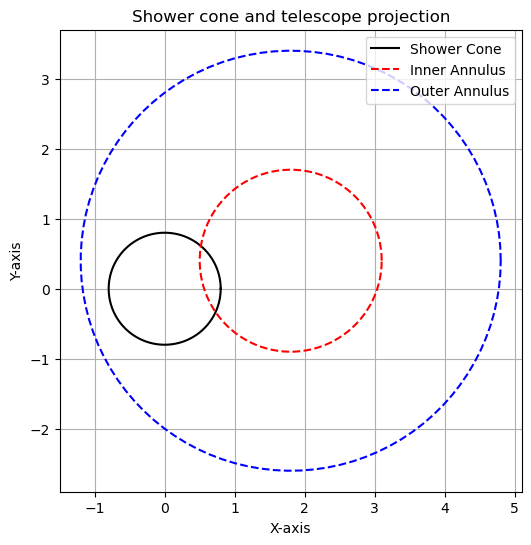

Case 5 identified.
Intersection points (x, y):  ((0.5171367070856844, 0.6103848181144214), (0.7269809399731395, -0.33391422987912717))
[285.6021999]


In [288]:
graphCircles(cone_pos=(0, 0), tel_pos=(1.8, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(1.8, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

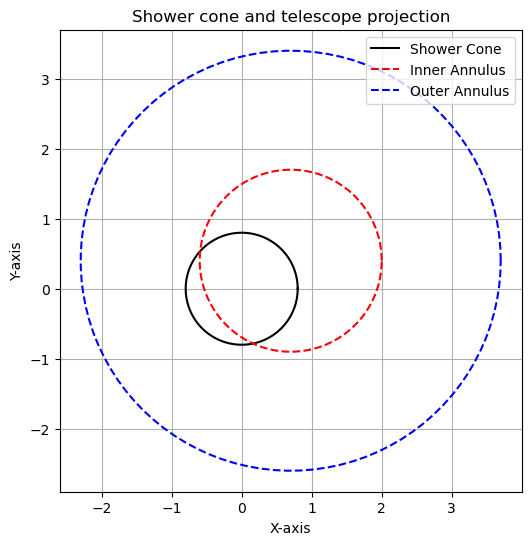

Case 5 identified.
Intersection points (x, y):  ((0.161962085335529, -0.7834336493371771), (-0.5927313161047605, 0.5372798031833308))
[143.87107253]


In [289]:
graphCircles(cone_pos=(0, 0), tel_pos=(0.7, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(0.7, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

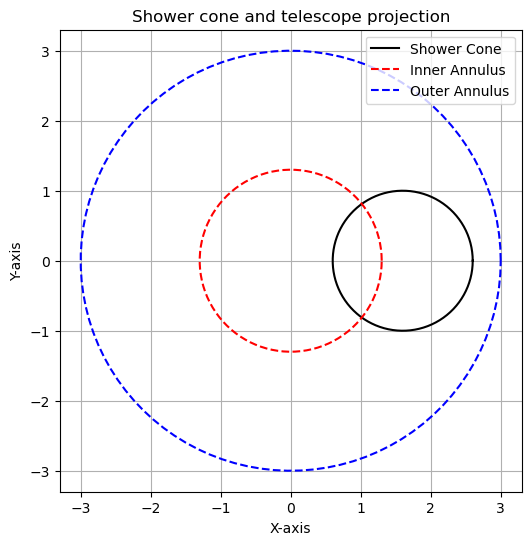

Case 5 identified.
Intersection points (x, y):  ((-0.5843750000000001, 0.811483739439676), (-0.5843750000000001, -0.811483739439676))
[251.51769778]


In [290]:
graphCircles(cone_pos=(1.6, 0), tel_pos=(0, 0), r_cone=1, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(1.6, 0), tel_pos=(0, 0), r_cone=1, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

* Doesn't work: getOmegas always returns the smaller angle.
* Returns a completely wrong angle when the majority of the cone is within the telescope core.

## Test for Case 6

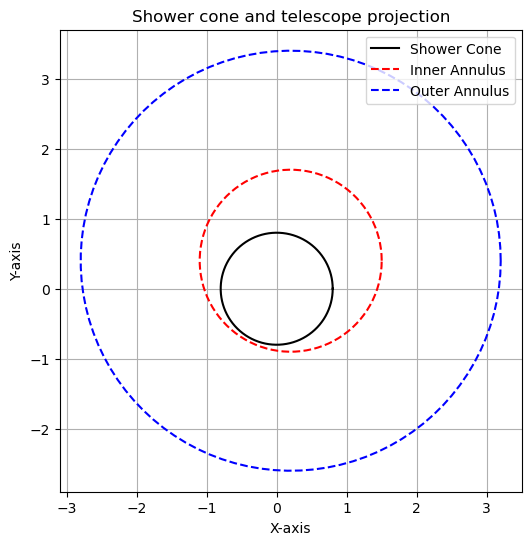

Case 6 identified.
[]


In [291]:
graphCircles(cone_pos=(0, 0), tel_pos=(.2, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(.2, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

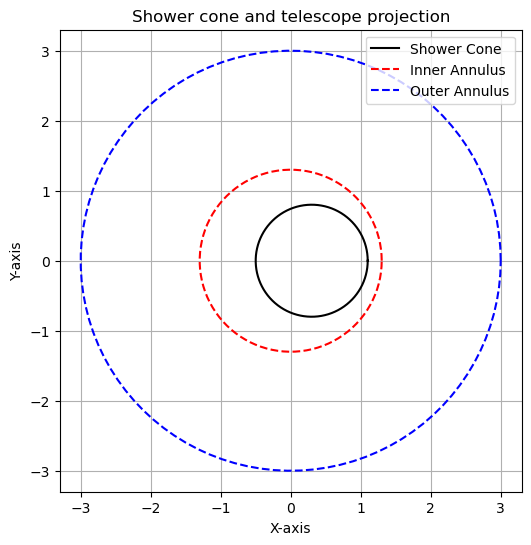

Case 6 identified.
[]


In [292]:
graphCircles(cone_pos=(.3, 0), tel_pos=(0, 0), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(.3, 0), tel_pos=(0, 0), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

* Works for when cone is centred at the origin and also when cone is not centred at the origin.

## Test for Case 7

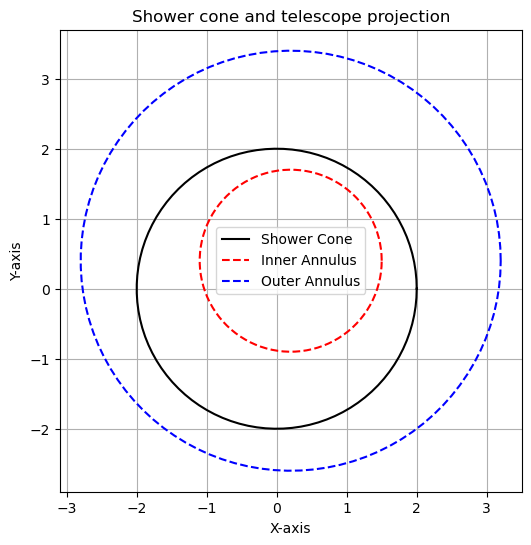

Case 7 identified.
[360.]


In [293]:
graphCircles(cone_pos=(0, 0), tel_pos=(.2, 0.4), r_cone=2, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(.2, 0.4), r_cone=2, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

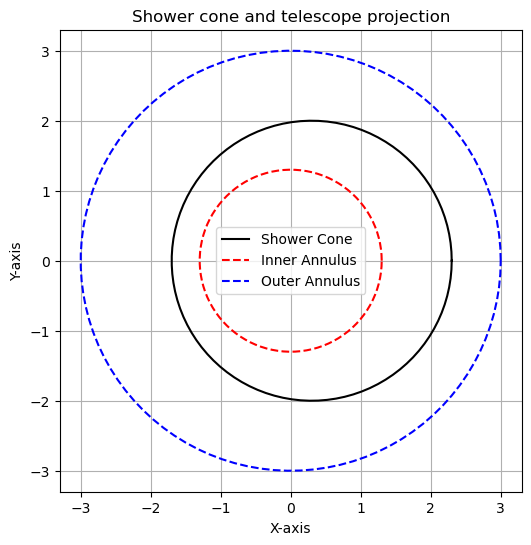

Case 7 identified.
[360.]


In [294]:
graphCircles(cone_pos=(.3, 0), tel_pos=(0, 0), r_cone=2, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(.3, 0), tel_pos=(0, 0), r_cone=2, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

* Works when cone is centred at the origin and also when it is not.

## Test for case 8

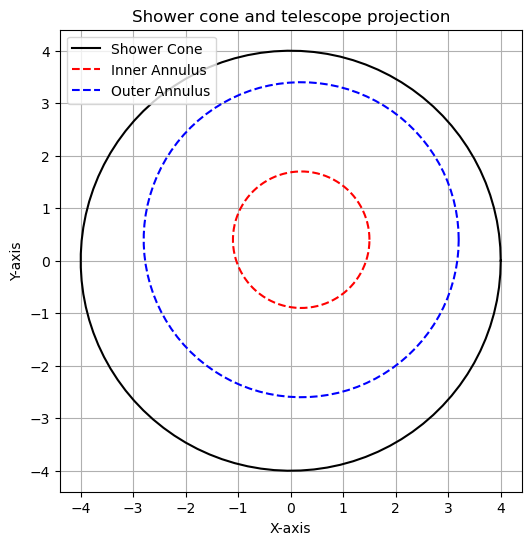

Case 8 identified.
[]


In [295]:
graphCircles(cone_pos=(0, 0), tel_pos=(.2, 0.4), r_cone=4, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(.2, 0.4), r_cone=4, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

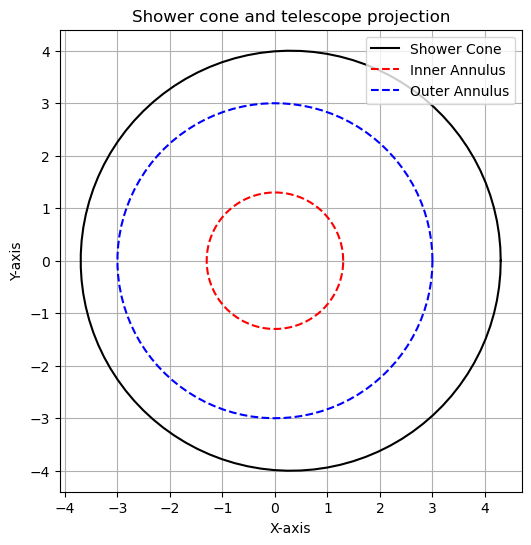

Case 8 identified.
[]


In [296]:
graphCircles(cone_pos=(.3, 0), tel_pos=(0, 0), r_cone=4, r_tel_core=1.3, r_tel_reach=3)
print(np.array(getOmegas(cone_pos=(.3, 0), tel_pos=(0, 0), r_cone=4, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

* Works when cone is centred at the origin and also when it is not.

In [297]:
print(np.array(getOmegas(cone_pos=(0, 0), tel_pos=(1.8, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3)) * 180/np.pi)

Case 5 identified.
Intersection points (x, y):  ((0.5171367070856844, 0.6103848181144214), (0.7269809399731395, -0.33391422987912717))
[285.6021999]


Case 5 identified.
Intersection points (x, y):  ((0.5171367070856844, 0.6103848181144214), (0.7269809399731395, -0.33391422987912717))


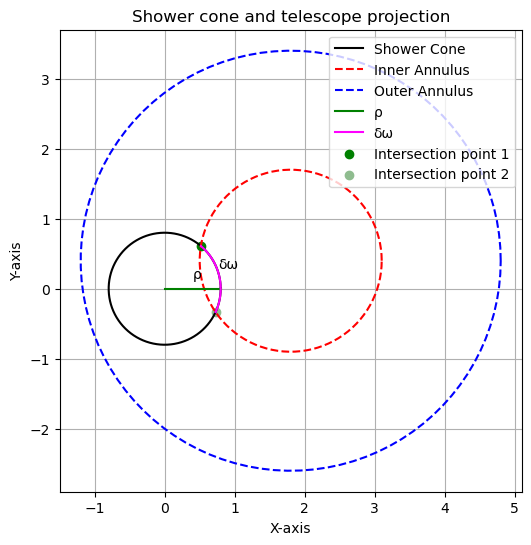

In [298]:
dw = np.array(getOmegas(cone_pos=(0, 0), tel_pos=(1.8, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3))* 180/np.pi
intersect_point_1 = (0.5171367070856844, 0.6103848181144214)
intersect_point_2 = (0.7269809399731395, -0.33391422987912717)

graphCircles(cone_pos=(0, 0), tel_pos=(1.8, 0.4), r_cone=0.8, r_tel_core=1.3, r_tel_reach=3, plot_variables=True, dw = dw, start = intersect_point_1, end = intersect_point_2)